# Imports

In [11]:
import os
import torch
from tqdm import tqdm
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import gc

if not os.path.exists('data'):
    new_directory_path = "..\\..\\"
    os.chdir(new_directory_path)


from src.eval.eval_metrics import precision,recall,create_cls_targets, accuracy, eval_reg
from src.eval.eval_utils import plt_training_metrics, gather_best_metrics
from src.eval.vis_scanpath import draw_scanpath_mpl
from src.model.model_io import load_models_with_data
from src.training.training_utils import move_data_to_device, compute_loss


## Methods

In [3]:
def get_coords(idx, x,y, fixation_len, reg_out):
    x_coords = x[idx,:,:2].cpu().numpy().T
    y_coords = y[idx,:fixation_len[idx],:2].cpu().numpy().T
    reg_coords = reg_out[idx,:fixation_len[idx],:2].cpu().numpy().T
    x_coords = x_coords[:,::-1]
    y_coords = y_coords[:,::-1]
    reg_coords = reg_coords[:,::-1]
    return x_coords, y_coords, reg_coords

def batch_to_list(x, fixation_len = None):
    # convert from padded batch [B,T,F] to list of numpy arrays with shape [F,N]
    x_list = []
    for i in range(x.size(0)):
        l = 0
        if fixation_len is None:
            l = x.size(1)
        else:
            l = fixation_len[i]
        x_i = x[i,:l, :].cpu().numpy().T
        x_list.append(x_i)
    return x_list

def plot_classification_scores(cls_out,fixation_len, title="Classification Scores"):
    acum = np.zeros(7)
    count = 0
    skipped_count = 0
    for i in range(cls_out.shape[0]):
        cls_out_sample = cls_out[i]
        cls_out_sample = torch.sigmoid(cls_out_sample).cpu().numpy().T
        if fixation_len[i] < 3 or fixation_len[i] > cls_out_sample.shape[1]-4:
            skipped_count += 1
            continue
        acum += cls_out_sample[0,fixation_len[i]-3: fixation_len[i]+4 ]
        count +=1
    avg = acum / count
    image_data = avg.reshape(7, 1).T
    plt.figure(figsize=(7,1)) # Set the figure size to be tall and thin
    plt.imshow(image_data, cmap='gray', interpolation='nearest', aspect='auto')
    text_color = 'green' 
    for i in range(image_data.shape[0]):
        for j in range(image_data.shape[1]):
            score = image_data[i, j]
            
            plt.text(j, i, f'{score:.2f}', 
                     ha="center", va="center", color=text_color, fontsize=10)
    print(f'Skipped samples: {skipped_count} out of {cls_out.shape[0]}')
    plt.title(title)
    plt.xticks(range(7), [f'Token {i-3}' if i != 3 else 'END' for i in range(7)]) # Optional: keep y-axis labels for reference
    plt.yticks([])
    plt.show()
    
def invert_transforms(inputs, outputs, dataloader):
    pred_reg = outputs['reg']
    gt_reg = inputs['tgt']
    transforms = dataloader.path_dataset.transforms
    # reverse the transforms
    for transform in reversed(transforms):
        if transform.modify_y:
            pred_reg = transform.inverse(pred_reg)
            gt_reg = transform.inverse(gt_reg)
    outputs['reg'] = pred_reg
    inputs['tgt'] = gt_reg
    return inputs, outputs



# Eval

## Review Metrics

In [4]:

# ckpt_path = ['outputs\\2025-11-19\\18-48-14',
#              'outputs\\2025-11-27\\17-35-19',
#              'outputs\\2025-11-28\\12-28-42'
#              ]
ckpt_path = ['outputs\\2025-12-03\\17-10-55']

metric_path = [os.path.join(p, 'metrics.json') for p in ckpt_path]

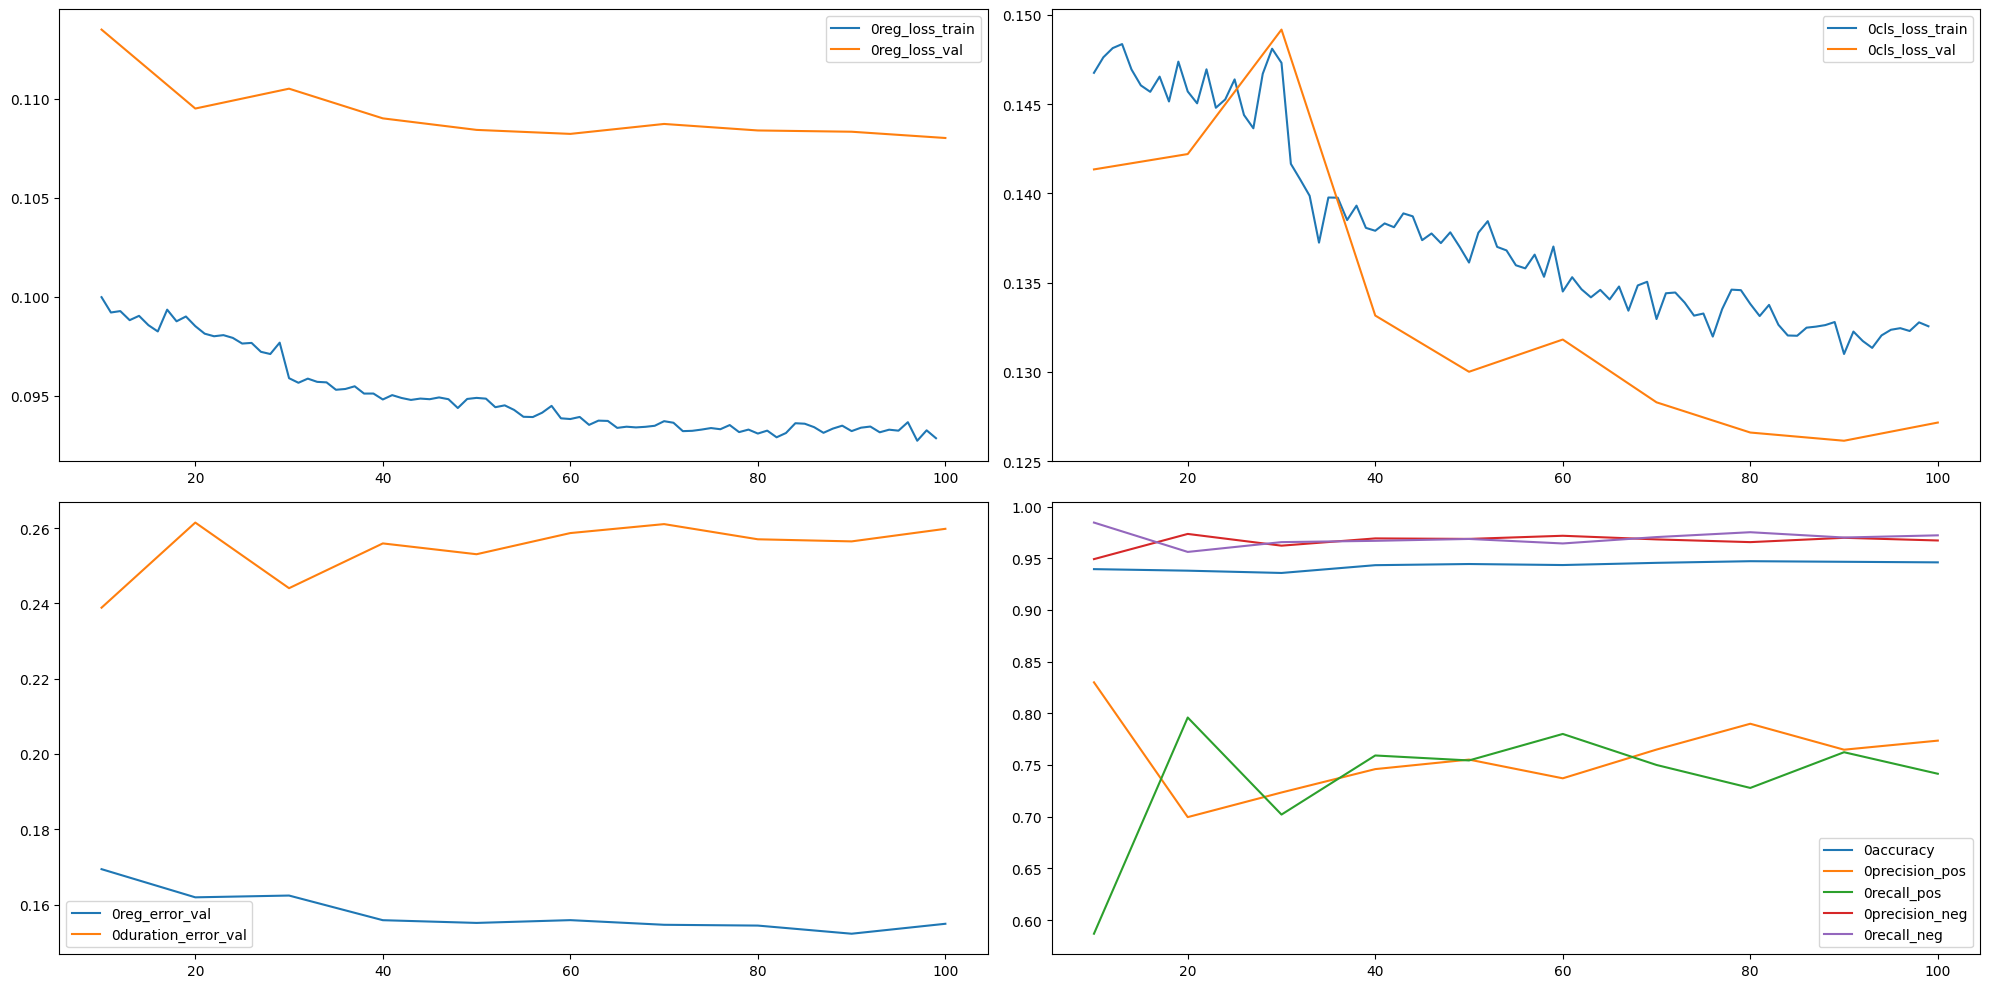

In [5]:
plt_training_metrics(metric_path, start_epoch=10)

In [6]:
ckpt_path = ['outputs\\2025-11-19\\18-48-14',
             'outputs\\2025-11-27\\17-35-19',
             'outputs\\2025-11-28\\12-28-42',
             'outputs\\2025-12-03\\17-10-55']

metric_path = [os.path.join(p, 'metrics.json') for p in ckpt_path]
gather_best_metrics(metric_path)

,epoch,reg_loss_train,reg_loss_val,cls_loss_train,cls_loss_val,accuracy,precision_pos,recall_pos,precision_neg,recall_neg,reg_error_val,duration_error_val
0,100,7607.521662,7566.260010,0.234150,0.233732,0.890130,0.741319,0.329663,0.913140,1.000000,NaN,NaN
1,100,8060.989434,6853.475754,0.262169,0.255997,0.887517,0.572673,0.119068,0.896838,1.000000,60.499606,68.711616
2,100,7479.535542,7927.933896,0.252484,0.254622,0.881869,0.587735,0.153930,0.892783,1.000000,68.865608,74.855592
3,100,0.092843,0.108017,0.132552,0.127158,0.947127,0.829949,0.795916,0.973512,0.984502,0.152242,0.238872


## Checkout Output

### Eval Just One Batch

In [7]:
input_outputs = torch.load('inputs_outputs_4.pth', map_location='cpu')

In [8]:
for i in range(4):
    print(f'Model {i}')
    input, output = input_outputs[i]
    cls_loss, reg_loss = compute_loss(input, output)
    print(f'Cls Loss: {cls_loss:.4f}, Reg Loss: {reg_loss:.4f}')
    reg_out, cls_out = output['reg'], output['cls']
    y, y_mask, fixation_len = input['tgt'], input['tgt_mask'], input['fixation_len']
    reg_error, dur_error = eval_reg(reg_out, y, y_mask)
    print(f'Regression error (pixels): {reg_error:.4f}, Duration error ({dur_error:.4f})')

Model 0
Cls Loss: 0.2268, Reg Loss: 6976.5547
Regression error (pixels): 67.8099, Duration error (87.4897)
Model 1
Cls Loss: 0.2548, Reg Loss: 7365.9263
Regression error (pixels): 72.5548, Duration error (89.5078)
Model 2
Cls Loss: 0.2452, Reg Loss: 7198.8945
Regression error (pixels): 64.3055, Duration error (94.6611)
Model 3
Cls Loss: 0.1162, Reg Loss: 8155.3647
Regression error (pixels): 94.3291, Duration error (80.6599)


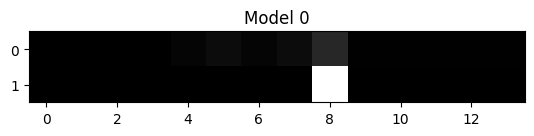

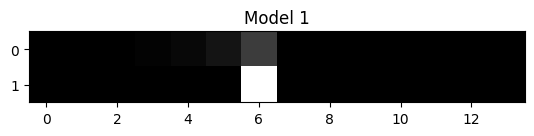

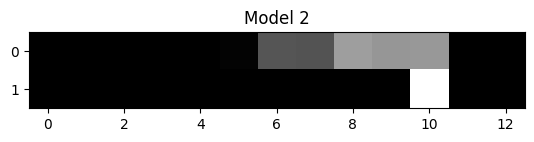

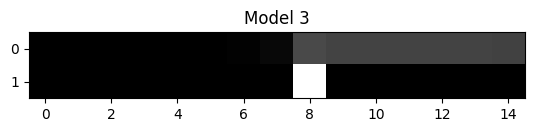

In [9]:
idx = randint(0,40 - 1)
for i, (input, output) in enumerate(input_outputs):
    reg_out, cls_out = output['reg'], output['cls']
    y, y_mask, fixation_len = input['tgt'], input['tgt_mask'], input['fixation_len']
    cls_out_sample = cls_out[idx]
    cls_out_sample = torch.sigmoid(cls_out_sample).cpu().numpy().T
    cls_targets = create_cls_targets(cls_out, fixation_len)
    cls_targets_sample = cls_targets[idx].cpu().numpy().T
    # vstack
    pair = np.vstack((cls_out_sample, cls_targets_sample)).T
    plt.imshow(pair.T, cmap='gray')
    plt.title(f'Model {i}')
    plt.show()

Skipped samples: 7 out of 128


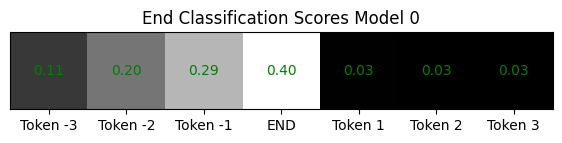

Skipped samples: 8 out of 128


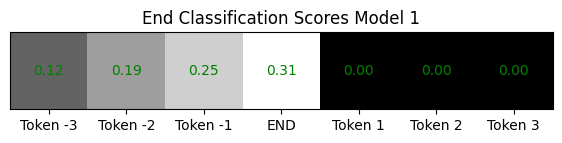

Skipped samples: 29 out of 128


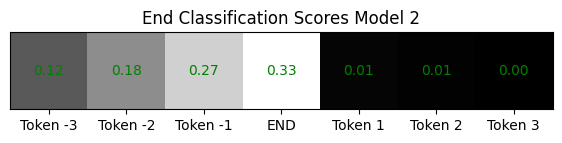

Skipped samples: 4 out of 128


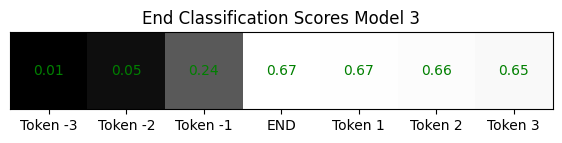

In [10]:

# put the value in each pixel
for i, (input, output) in enumerate(input_outputs):
    reg_out, cls_out = output['reg'], output['cls']
    y, y_mask, fixation_len = input['tgt'], input['tgt_mask'], input['fixation_len']
    plot_classification_scores(cls_out, fixation_len, title=f"End Classification Scores Model {i}")

In [28]:
from pathlib import Path
import json

out = Path('outputs')
path_list = []
model_best_coord_error = []
model_best_recall_pos = []
for output_path in out.rglob('*.json'):
    with open(str(output_path), 'r') as f:
        metric = json.load(f)
    if 'reg_error_val' not in metric:
        continue
    path_list.append(output_path)
    model_best_coord_error.append( min(metric['reg_error_val']))
    model_best_recall_pos.append( max(metric['recall_pos']))
    
    

In [29]:

idx.sort(key = lambda x: model_best_coord_error[x])
for i in idx[:4]:
    print(str(path_list[i]), f' {model_best_coord_error[i]}')
idx.sort(key = lambda x: model_best_recall_pos[x])
for i in idx[:4]:
    print(str(path_list[i]), f' {model_best_recall_pos[i]}')

outputs\2025-12-03\17-10-55\metrics.json  0.15224150842741915
outputs\2025-11-27\17-35-19\metrics.json  60.4996058344841
outputs\2025-11-28\12-28-42\metrics.json  68.86560773092603
outputs\2025-11-27\17-35-19\metrics.json  0.11906828703703703
outputs\2025-11-28\12-28-42\metrics.json  0.15392992424242424
outputs\2025-12-03\17-10-55\metrics.json  0.7959155701754386


[1, 0, 2]

outputs\2025-11-28\12-28-42\metrics.json  0.11906828703703703
outputs\2025-11-27\17-35-19\metrics.json  60.4996058344841
outputs\2025-12-03\17-10-55\metrics.json  68.86560773092603


In [11]:


for i in range(5):
    idx = randint(0,128-1)
    for j , out in enumerate(outputs):
        reg_out, cls_out = out
        x_coords, y_coords, reg_coords = get_coords(idx, x, y, fixation_len,reg_out)
        img = np.ones((320,512,3),dtype=np.uint8)*255

        label = ['sim', 'gt', 'pred']

        traj = [x_coords,
                y_coords, 
                reg_coords]
        traj_colors = [(40/255, 116/255, 166/255), # blue
                    (202/255, 111/255, 30/255), # orange
                    (29/255, 131/255, 72/255)] # green

        end_point_colors = [(133/255, 193/255, 233/255),
                            (245/255, 203/255, 167/255),
                            (169/255, 223/255, 191/255)]
        fig, ax = plt.subplots(figsize=(8,8))
        for traj, color, end_color, lbl in zip(traj, traj_colors, end_point_colors, label):
            ax = draw_scanpath_mpl(ax, traj[0],traj[1], color=color, end_color=end_color, label=lbl)

        print(fixation_len[idx])
        plt.title(f'Scanpath Sample {idx} Model {j}')
        plt.imshow(img)
        plt.legend()
        plt.savefig(f'Output/scanpath_{i}_model_{j}.png')
        plt.show()


NameError: name 'outputs' is not defined

### Load Stats


In [12]:
acc_list = []
reg_loss_list = []
cls_loss_list = []
pre_pos_list = []
rec_pos_list = []
pre_neg_list = []
rec_neg_list = []
coord_error_list = []
dur_error_list = []
all_model_x_list = []
all_model_y_list = []
all_model_reg_list = []
for i in range(4) :
    path = f'all_outputs_model_{i + 1}.pth'
    all_outputs = torch.load(path, map_location='cpu', weights_only=False)
    print(all_outputs.keys())
    all_model_x_list.append(all_outputs['x_results'])
    all_model_y_list.append(all_outputs['y_results'])
    all_model_reg_list.append(all_outputs['reg_list'])
    reg_loss_list.append(all_outputs['reg_loss_list'])
    cls_loss_list.append(all_outputs['cls_loss_list'])
    acc_list.append(all_outputs['acc_list'])
    pre_pos_list.append(all_outputs['pre_pos_list'])
    rec_pos_list.append(all_outputs['rec_pos_list'])
    pre_neg_list.append(all_outputs['pre_neg_list'])
    rec_neg_list.append(all_outputs['rec_neg_list'])
    coord_error_list.append(all_outputs['coord_error_list'])
    dur_error_list.append(all_outputs['dur_error_list'])

dict_keys(['y_results', 'x_results', 'reg_list', 'cls_loss_list', 'reg_loss_list', 'coord_error_list', 'dur_error_list', 'acc_list', 'pre_pos_list', 'rec_pos_list', 'pre_neg_list', 'rec_neg_list'])
dict_keys(['y_results', 'x_results', 'reg_list', 'cls_loss_list', 'reg_loss_list', 'coord_error_list', 'dur_error_list', 'acc_list', 'pre_pos_list', 'rec_pos_list', 'pre_neg_list', 'rec_neg_list'])
dict_keys(['y_results', 'x_results', 'reg_list', 'cls_loss_list', 'reg_loss_list', 'coord_error_list', 'dur_error_list', 'acc_list', 'pre_pos_list', 'rec_pos_list', 'pre_neg_list', 'rec_neg_list'])
dict_keys(['y_results', 'x_results', 'reg_list', 'cls_loss_list', 'reg_loss_list', 'coord_error_list', 'dur_error_list', 'acc_list', 'pre_pos_list', 'rec_pos_list', 'pre_neg_list', 'rec_neg_list'])


In [13]:
# plot evaluation metrics using pandas 
import pandas as pd
# Transpose the dataframe so models are columns and metrics are rows
metrics_df = pd.DataFrame({
    'Reg_Loss': reg_loss_list,
    'Cls_Loss': cls_loss_list,
    'Accuracy': acc_list,
    'Precision_Pos': pre_pos_list,
    'Recall_Pos': rec_pos_list,
    'Precision_Neg': pre_neg_list,
    'Recall_Neg': rec_neg_list,
    'Coord_Error': coord_error_list,
    'Dur_Error': dur_error_list
}, index=[f'Model_{i}' for i in range(len(acc_list))])
metrics_df = metrics_df.transpose()
metrics_df

,Model_0,Model_1,Model_2,Model_3
Reg_Loss,7571.597523,8362.367808,7748.613388,8627.305195
Cls_Loss,0.234930,0.262670,0.249930,0.128716
Accuracy,0.888651,0.879103,0.887771,0.945769
Precision_Pos,0.584025,0.533720,0.525799,0.813575
Recall_Pos,0.278555,0.119436,0.174719,0.726026
Precision_Neg,0.907807,0.889675,0.902653,0.962257
Recall_Neg,0.972172,0.984453,0.979022,0.976540
Coord_Error,69.354879,74.675157,66.465910,89.787817
Dur_Error,92.137705,96.460210,98.180444,88.011935


In [14]:
gaze_list = [#(all_model_x_list[-1],'sim_noise',1/16), 
             (all_model_y_list[-1],'gt',1/16), 
             *[(all_model_reg_list[i],f'pred {i}', 1/16) for i in range(len(all_model_reg_list))]]

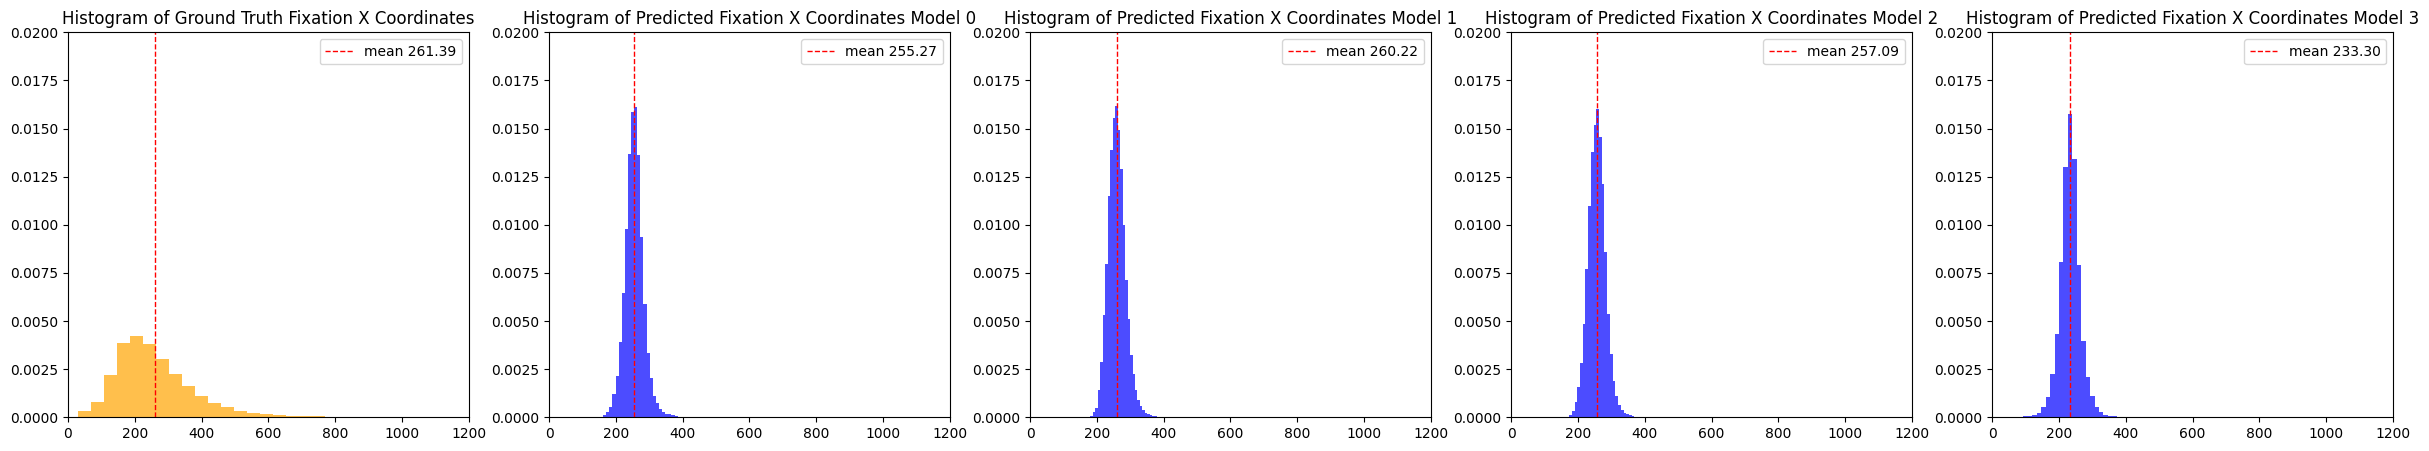

In [15]:
concatenated_y = np.concat([y[2] for y in all_model_y_list[-1]])

# plot a hist of each array in two subplots
fig, axs = plt.subplots(1,1 + len(all_model_reg_list), figsize=(6*(1 + len(all_model_reg_list)),  5))
axs[0].hist(concatenated_y, bins=30, color='orange', alpha=0.7, density=True)
axs[0].set_title('Histogram of Ground Truth Fixation X Coordinates')
axs[0].set_xlim(0, 1200)
axs[0].set_ylim(0, 0.020)
axs[0].axvline(np.mean(concatenated_y), color='red', linestyle='dashed', linewidth=1, label = f'mean {np.mean(concatenated_y):.2f}')
axs[0].legend()
for i in range(len(all_model_reg_list)):
    concatenated_reg = np.concat([reg[2] for reg in all_model_reg_list[i]])
    axs[i+1].hist(concatenated_reg, bins=30, color='blue', alpha=0.7, density=True)
    axs[i+1].set_title(f'Histogram of Predicted Fixation X Coordinates Model {i}')
    axs[i+1].set_xlim(0, 1200)
    axs[i+1].set_ylim(0, 0.020)
    axs[i+1].axvline(np.mean(concatenated_reg), color='red', linestyle='dashed', linewidth=1, label = f'mean {np.mean(concatenated_reg):.2f}')
    axs[i+1].legend()
plt.show()

    


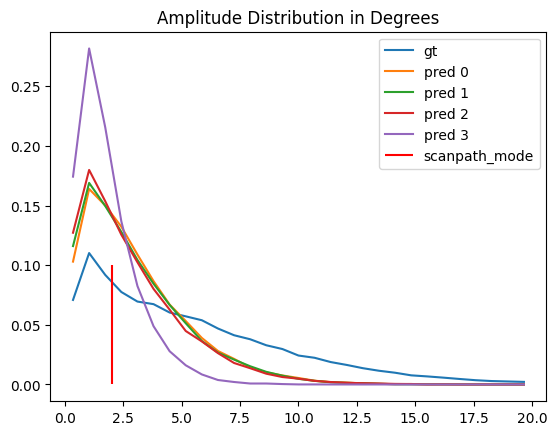

In [21]:
from src.eval.eval_utils import plot_amplitude_dist, plot_angle_distribution, plot_autocorrelation, plot_consecutive_angles, plot_vector_dist, calculate_relative_vectors                        
plot_amplitude_dist([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list],
                    [gaze[2] for gaze in gaze_list])

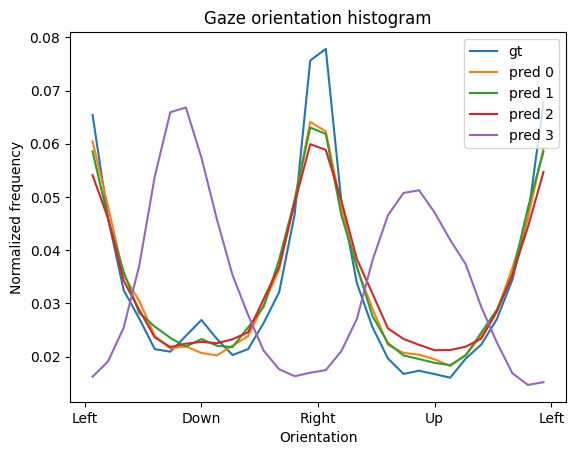

In [22]:
plot_angle_distribution([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list])
plt.show()

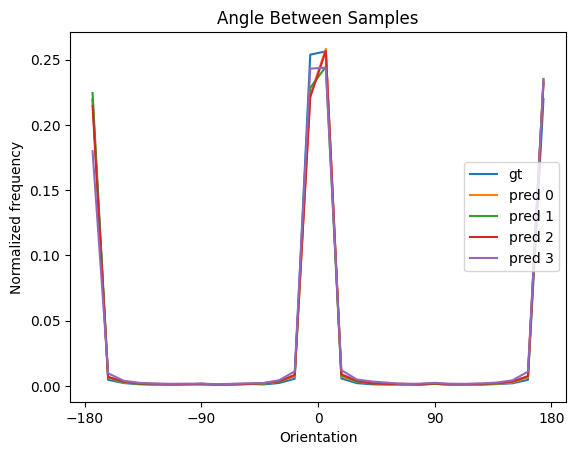

In [23]:
plot_consecutive_angles([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list])
plt.show()

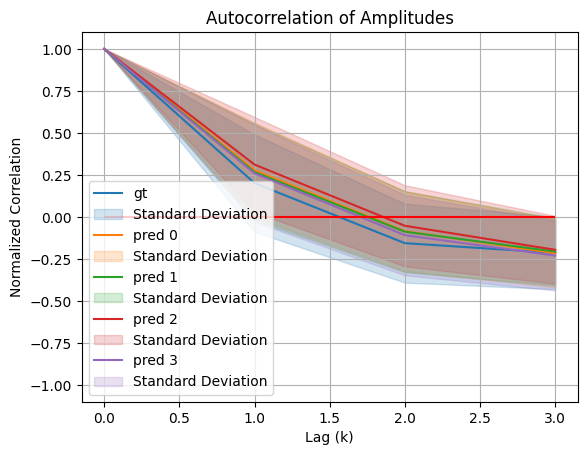

In [24]:
plot_autocorrelation([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list], min_len=4)
plt.show()

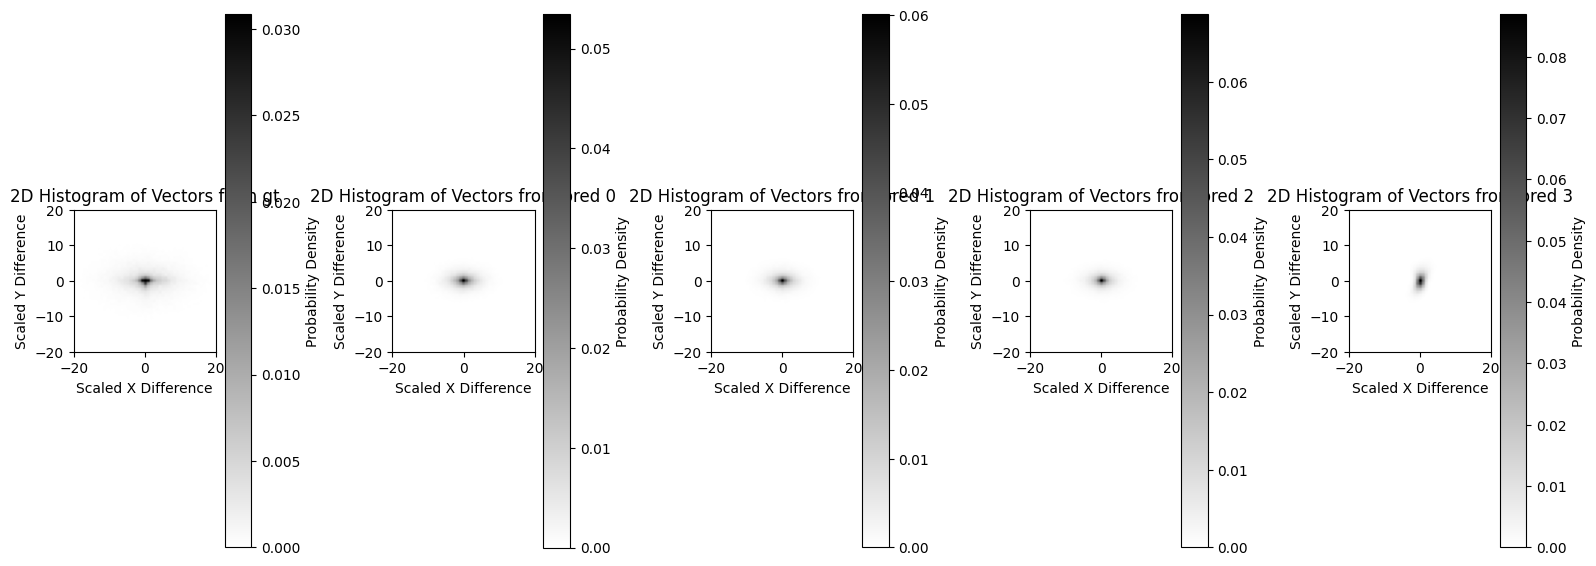

In [25]:
plot_vector_dist([[np.diff(gaze_sample[:2, :], axis=1) for gaze_sample in gaze[0]] for gaze in gaze_list],
                 [gaze[2] for gaze in gaze_list], 
                 [gaze[1] for gaze in gaze_list],)

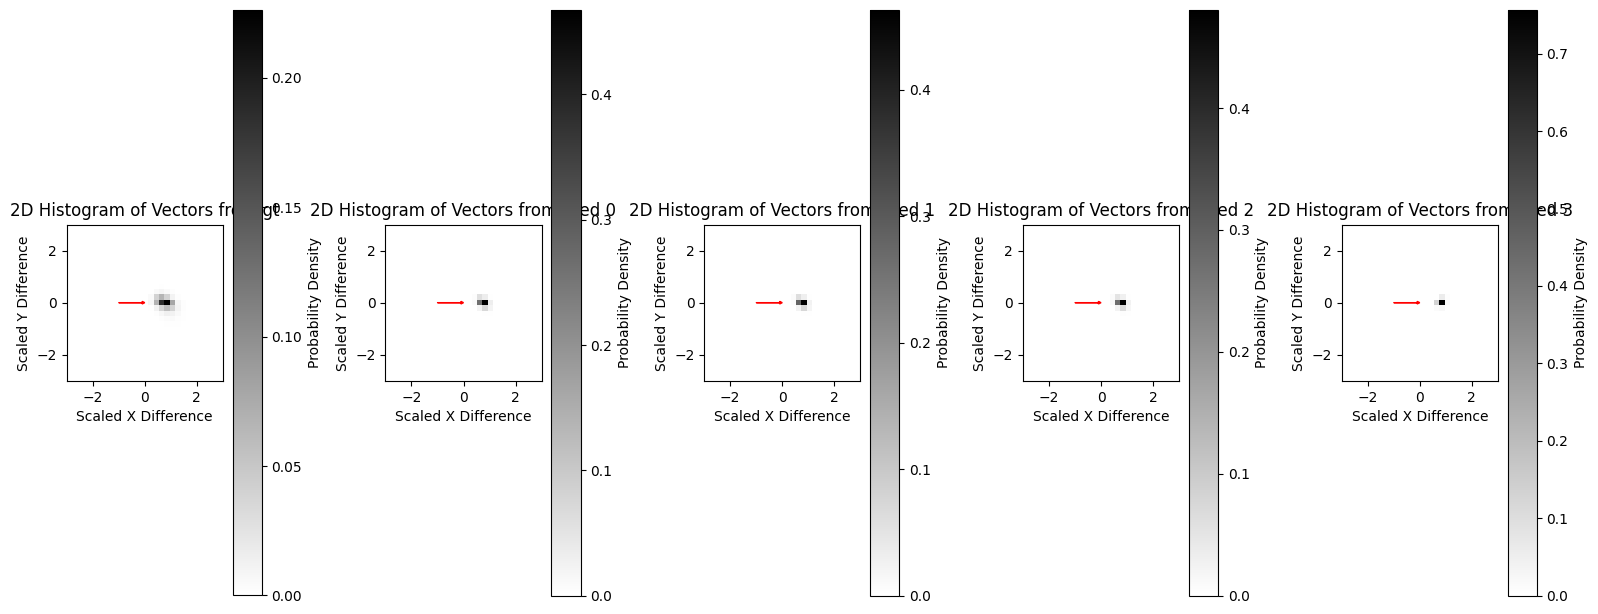

In [26]:
plot_vector_dist([[calculate_relative_vectors(gaze_sample) for gaze_sample in gaze[0]] for gaze in gaze_list],
                    [1 for _ in gaze_list],
                    [gaze[1] for gaze in gaze_list],-3,3,30, arrow= True)

plt.show()